# Rejection project with fixed group size
This experrimentation is the continuation of the exp described in file "./Rejection-groups-of-size-one". the following 
permits to the algorithm to define the number of group for the execution. In addition, it is possible to choose the percentage of resources used for the rejection.

## Decription of the results

The file `../data/rej-result-groups-fixed.tar.xz` contains thecompressed csv.

The experiments simulated 3 différents clusters (Curie - 5000 nodes, Metacentrum - 47 nodes, sdscblue 144 nodes), using a resampling methode //TODO.
The files are organized as showed in the bash script.

In [4]:
%%bash 
# To decompress and ge the results
# tar -xJf ../data/results/results_groups_fixed/rej-result-groups-fixed.tar.xz

BASE_FOLER=../data/results/group_size_results/save/results
# List of workload by cluster
ls $BASE_FOLER/curie/ |head -1
ls $BASE_FOLER/metacentrum/ |head -1
ls $BASE_FOLER/sdscblue/ |head -1
echo ""

# Example of folder generated for each simulation
echo "The folder name means t100 -> rejectionn threshold"
echo "The second parameters -> rejection size"
echo "The third -> Number of groups"
echo "" 

ls $BASE_FOLER/curie/curie_1w_43659000/  |head -1
ls $BASE_FOLER/curie/curie_1w_43659000/ \
|head -1| awk -F "_" '{print("rejection size " $1 ". Percentage of node used for the rejection " $2 ". Number of groups " $3);}'
echo ""

ls $BASE_FOLER/metacentrum/metacentrum_1w_1360041254/ |head -1
ls $BASE_FOLER/metacentrum/metacentrum_1w_1360041254/ \
|head -1| awk -F "_" '{print("rejection size " $1 ". Percentage of node used for the rejection " $2 ". Number of groups " $3);}'
echo ""

ls $BASE_FOLER/sdscblue/sdscblue_1w_10166421/ |head -1
ls $BASE_FOLER/sdscblue/sdscblue_1w_10166421/\
|head -1| awk -F "_" '{print("rejection size " $1 ". Percentage of node used for the rejection " $2 ". Number of groups " $3);}'
echo ""

curie_1w_43659000
metacentrum_1w_1360041254
sdscblue_1w_10166421

The folder name means t100 -> rejectionn threshold
The second parameters -> rejection size
The third -> Number of groups

t100_5.0_10
rejection size t100. Percentage of node used for the rejection 5.0. Number of groups 10

t100_5.0_2
rejection size t100. Percentage of node used for the rejection 5.0. Number of groups 2

t100_5.0_4
rejection size t100. Percentage of node used for the rejection 5.0. Number of groups 4



## Transformation 

Before we can analyse the results, we need to apply the script "merge_killed_jobs.py" on every results of each simulation. This script is used to merge the initials jobs with the killed ones.

The script can be used with the helper '../scripts/merge_parallel.sh', that will parralelize the whole calculation.

## Python setup

In order to analyse the results we use the library evalys, wich is a set of tools defined to analysis hpc workload. 
It support multiple format (such as swf) and can direclty read batsim output files.

We also use matplot lib and pandas as dependencies. The cell below initialise and imports the dependencies we need.

In [1]:
# In the first place we load libraries

# Evalys uses matplotlib to visualize, so lets load it.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from numpy import genfromtxt

# We load the jobset module, which allows to compute
# metrics and visualize workloads from batsim
from evalys.jobset import JobSet
from evalys import visu
from evalys import metrics

In [2]:
# Defines some variables relevant for the whole analysis
base_folder="../data/results/group_size_results/save/results/"

In [3]:
# //TODO create a dedicated script

# Script that constructs the aggregation of metrics for all clusters
# It creates a csv file 'aggregation.csv' with the following formats:
# 'cluster,workload,nb_groups,threshold,rejection_percentage,consumed_joules,makespan,
# max_slowdown,max_turnaround_time,max_waiting_time,mean_slowdown,mean_turnaround_time,mean_waiting_time,
# nb_computing_machines,nb_grouped_switches,nb_jobs'

# ./data/results/group_size_results/save/results/aggregation.csv
final_file = os.path.join(base_folder, "aggregation.csv")

clusters = [ name for name in os.listdir(base_folder, ) if os.path.isdir(os.path.join(base_folder, name)) ]

list_ = []
for cluster in clusters:
    cluster_path = os.path.join(base_folder, cluster)
    workloads = [ name for name in os.listdir(cluster_path) if os.path.isdir(os.path.join(cluster_path, name)) ]
    for folder in workloads:  
        folder_path = os.path.join(cluster_path, folder)
        entry_param = [ name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name)) ]
        for entry in entry_param:
            params = entry.split('_')

            final_path= os.path.join(folder_path, entry)
            
            summary_file = os.path.join(final_path, "out_schedule.csv")
            df = pd.read_csv(summary_file)
            df.insert(0, "rejection_percentage", params[1])
            df.insert(0, 'threshold', params[0][1:])
            df.insert(0, "nb_groups", params[2])
            df.insert(0, "workload", folder)
            df.insert(0, "cluster", folder.split("_")[0])
            list_.append(df)

aggregation = pd.concat(list_)
aggregation.to_csv(final_file, index=False)

## Makespan

In the first place I noticed that some simulations have some poor results for the makespan.
The following block code plot the make span of the simulation according to two parameters.
The number of groups and the rejection threshold. 

/nix/store/nha09v0wrj98w24kw32hpc3pgn3vflxn-python3.6-matplotlib-2.0.2/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


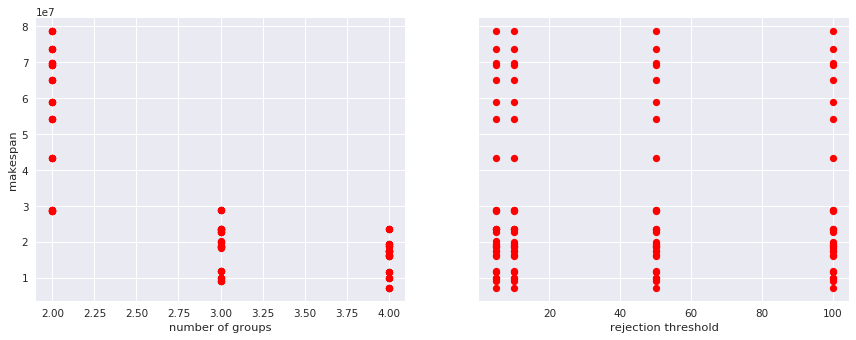

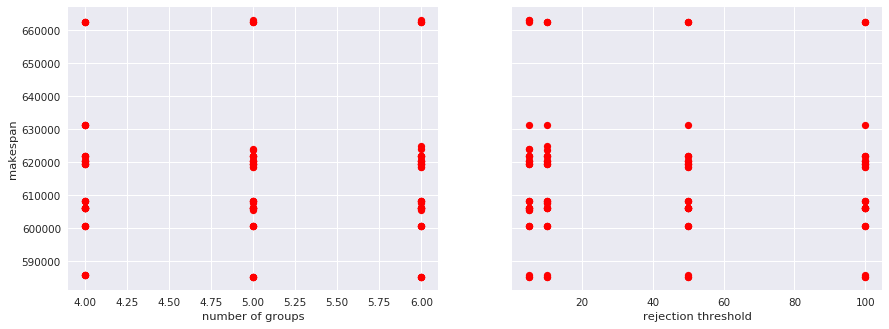

In [21]:
# Add workload in legend

matplotlib.rcParams['figure.dpi'] = 75
matplotlib.rcParams['figure.figsize'] = 14, 5

curie = aggregation[aggregation["cluster"] == "curie"]
metacentrum = aggregation[aggregation["cluster"] == "metacentrum"]
sdsc = aggregation[aggregation["cluster"] == "sdscblue"]

fig, axe = plt.subplots(ncols=2, sharey=True)
axe[0].plot(curie["nb_groups"], curie["makespan"] , 'ro')
axe[1].plot(curie["threshold"], curie["makespan"] , 'ro')

axe[0].set_ylabel("makespan")
axe[0].set_xlabel("number of groups")
axe[1].set_xlabel("rejection threshold")

fig, axe = plt.subplots(ncols=2, sharey=True)
axe[0].plot(metacentrum["nb_groups"], metacentrum["makespan"] , 'ro')
axe[1].plot(metacentrum["threshold"], metacentrum["makespan"] , 'ro')
axe[0].set_ylabel("makespan")
axe[0].set_xlabel("number of groups")
axe[1].set_xlabel("rejection threshold")

fig, axe = plt.subplots(ncols=2, sharey=True)
axe[0].plot(sdsc["nb_groups"], sdsc["makespan"] , 'ro')
axe[1].plot(sdsc["threshold"], sdsc["makespan"] , 'ro')
axe[0].set_ylabel("makespan")
axe[0].set_xlabel("number of groups")
axe[1].set_xlabel("rejection threshold")

## Look of the schedule 

The following plot are shown to see the global "look" of the algorithm.
we can see the differents group scheduled. The smallest group starts from the bottom
of the gant. While on the top, we can see the rejection part using Easy backfilling.

### Curie

We can see in the top chart the rejection use the top part of the cluster.
The bottom chart 

/nix/store/nha09v0wrj98w24kw32hpc3pgn3vflxn-python3.6-matplotlib-2.0.2/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


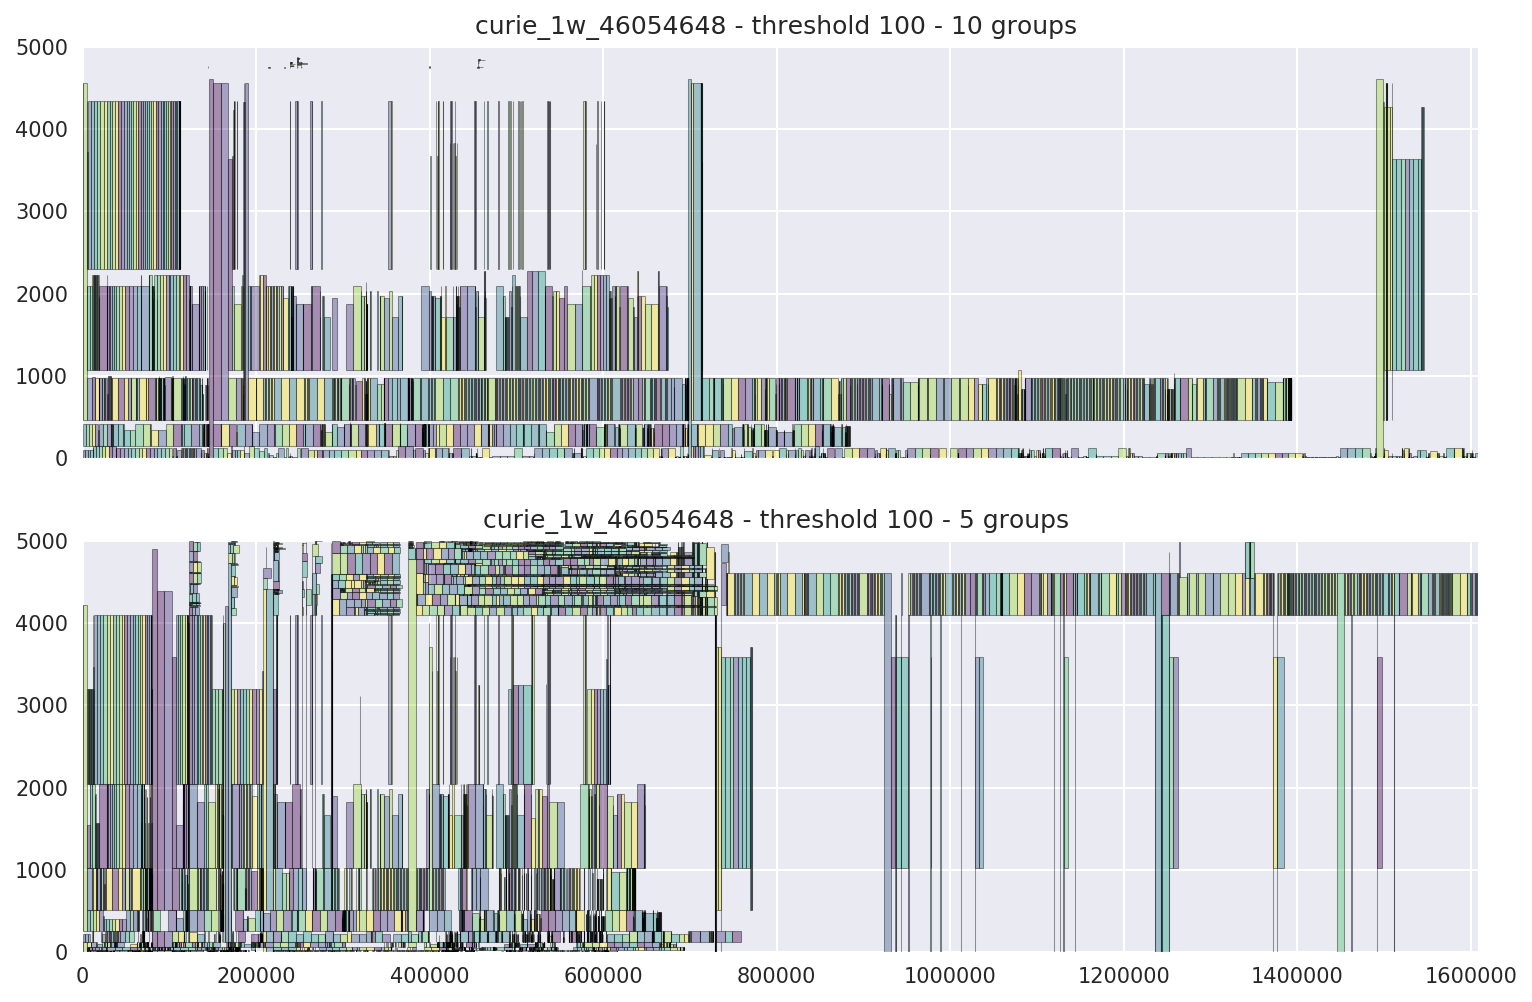

In [6]:
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['savefig.dpi'] = 300
# matplotlib.rcParams['figure.figsize'] = 30, 15

t10 = JobSet.from_csv(os.path.join(base_folder, "curie/curie_1w_46054648/t100_5.0_5/merged_jobs.csv"))
t5 = JobSet.from_csv(os.path.join(base_folder, "curie/curie_1w_46054648/t100_5.0_12/merged_jobs.csv"))

fig, axe = plt.subplots(nrows=2, sharex=True)
visu.plot_gantt(t10, ax=axe[0], labels=False)
axe[0].set_title("curie_1w_46054648 - threshold 100 - 10 groups ")

visu.plot_gantt(t5, ax=axe[1], labels=False)
axe[1].set_title("curie_1w_46054648 - threshold 100 - 5 groups ")

plt.savefig(os.path.join(base_folder, "curie_simple_gantt.png"))
plt.show()

### Metacentrum
Notes:
There is a lot of small jobs, it may be a good idea to try simulations using a bigger part for the rejection.

/nix/store/nha09v0wrj98w24kw32hpc3pgn3vflxn-python3.6-matplotlib-2.0.2/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


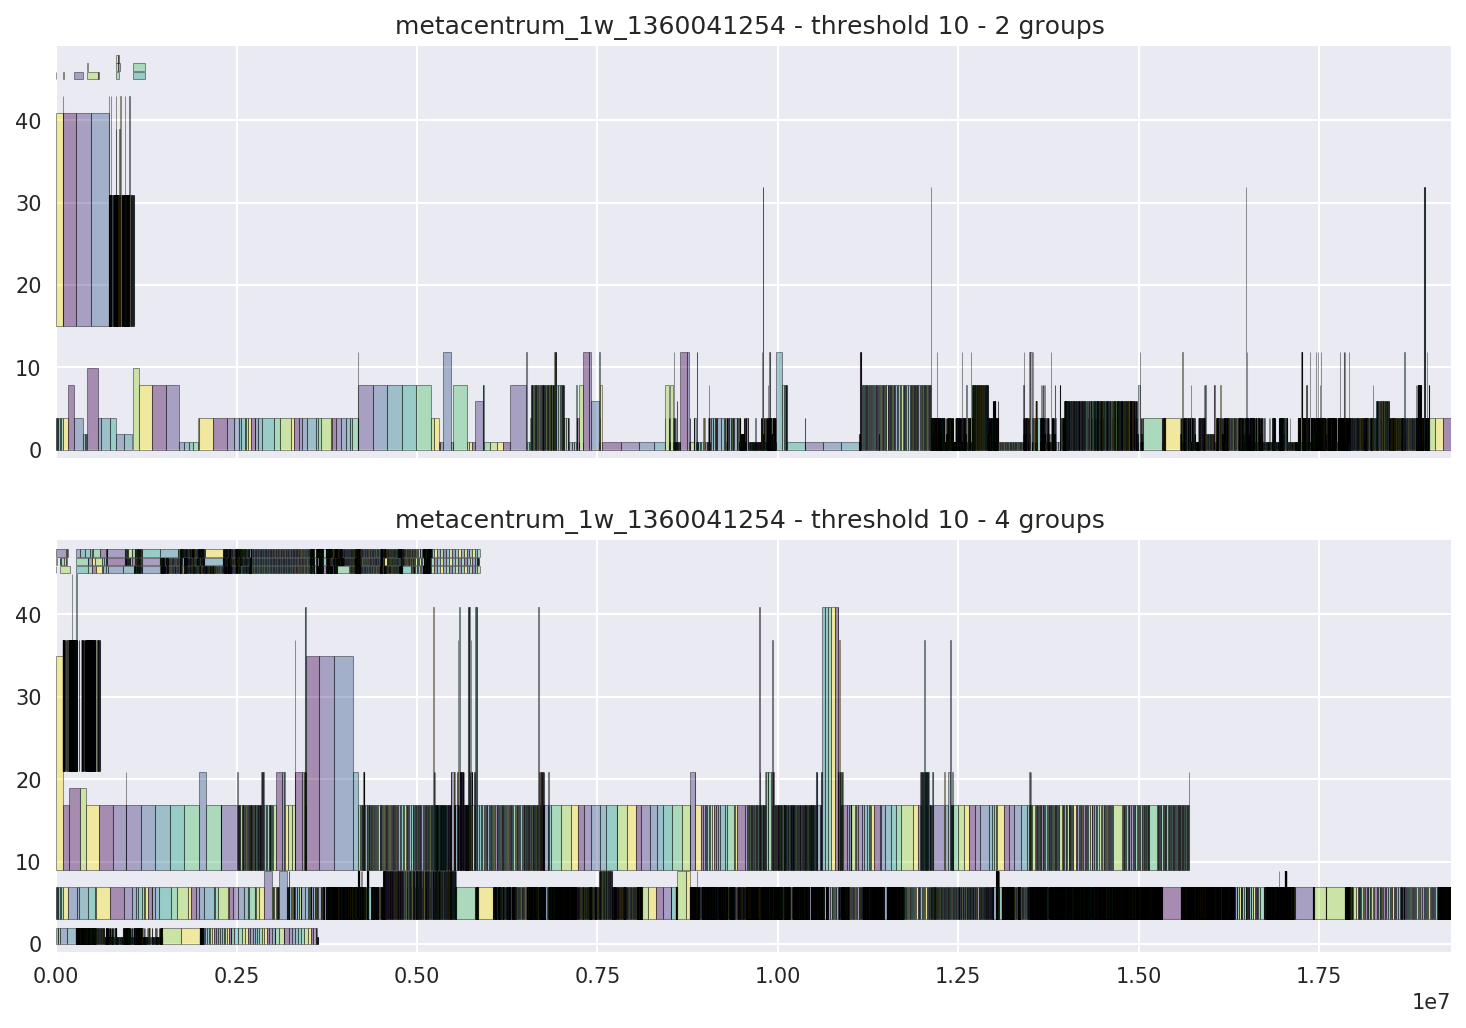

In [39]:
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['savefig.dpi'] = 300
# matplotlib.rcParams['figure.figsize'] = 30, 15

t10 = JobSet.from_csv(os.path.join(base_folder, "metacentrum/metacentrum_1w_1360041254/t5_5.0_2/merged_jobs.csv"))
t5 = JobSet.from_csv(os.path.join(base_folder, "metacentrum/metacentrum_1w_1360041254/t5_5.0_4/merged_jobs.csv"))

fig, axe = plt.subplots(nrows=2, sharex=True)
visu.plot_gantt(t10, ax=axe[0], labels=False)
axe[0].set_title("metacentrum_1w_1360041254 - threshold 10 - 2 groups ")

visu.plot_gantt(t5, ax=axe[1], labels=False)
axe[1].set_title("metacentrum_1w_1360041254 - threshold 10 - 4 groups ")

plt.savefig(os.path.join(base_folder, "metacentrum_simple_gantt.png"))
plt.show()

### Sdcblue

/nix/store/nha09v0wrj98w24kw32hpc3pgn3vflxn-python3.6-matplotlib-2.0.2/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


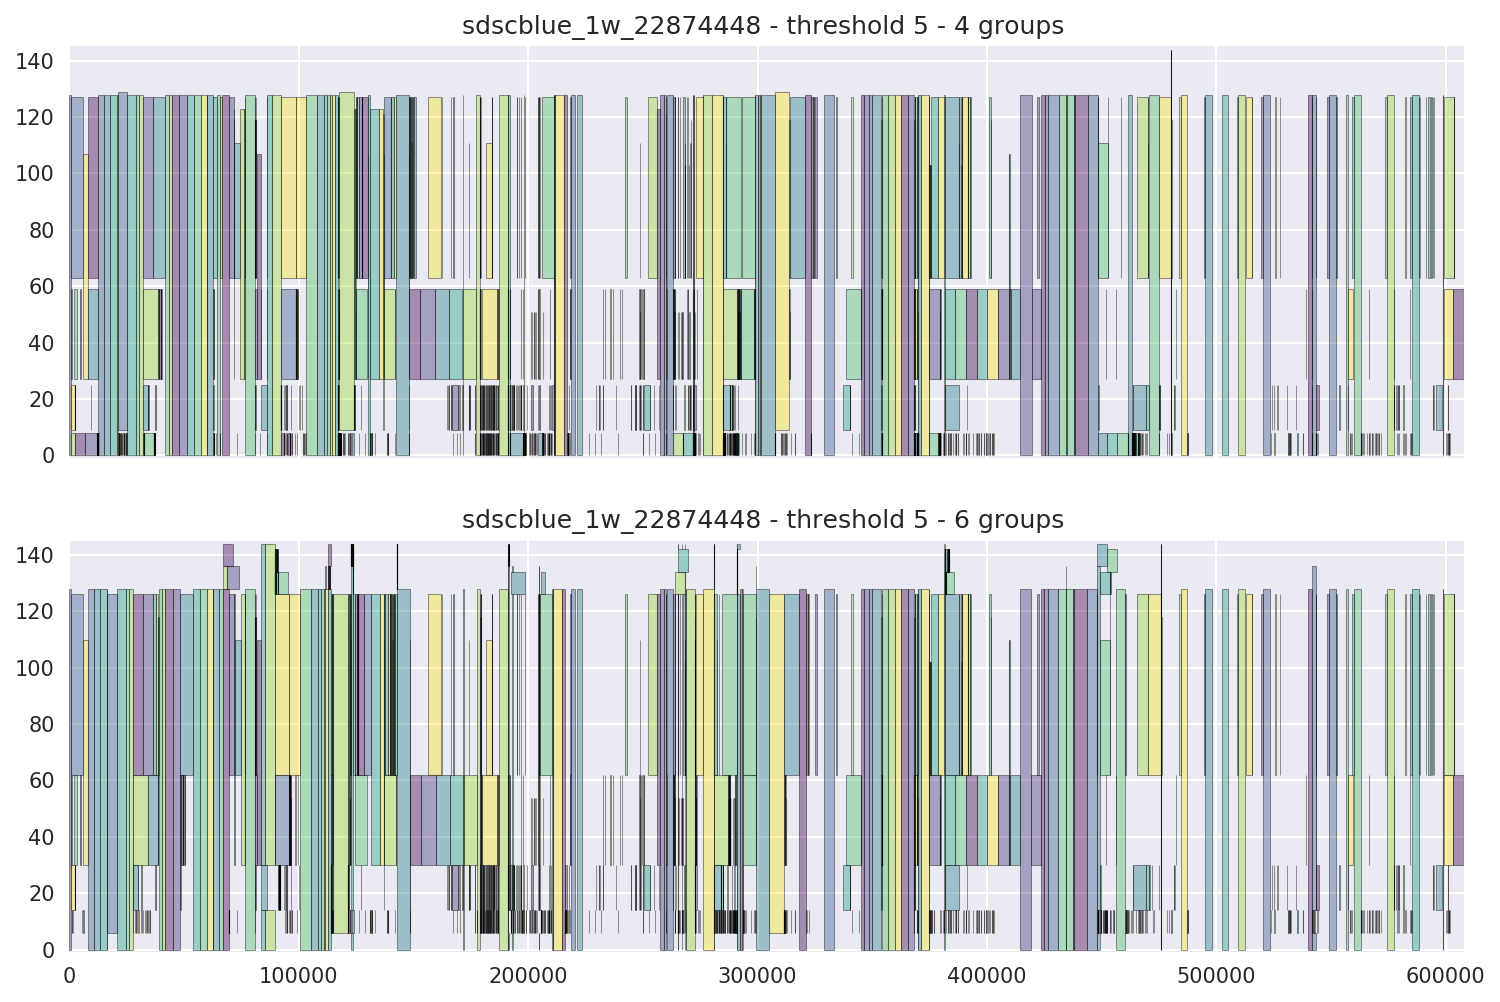

In [43]:
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['savefig.dpi'] = 300
# matplotlib.rcParams['figure.figsize'] = 30, 15

t4 = JobSet.from_csv(os.path.join(base_folder, "sdscblue/sdscblue_1w_22874448/t5_5.0_4/merged_jobs.csv"))
t6 = JobSet.from_csv(os.path.join(base_folder, "sdscblue/sdscblue_1w_22874448/t5_5.0_6/merged_jobs.csv"))

fig, axe = plt.subplots(nrows=2, sharex=True)
visu.plot_gantt(t4, ax=axe[0], labels=False)
axe[0].set_title("sdscblue_1w_22874448 - threshold 5 - 4 groups ")

visu.plot_gantt(t6, ax=axe[1], labels=False)
axe[1].set_title("sdscblue_1w_22874448 - threshold 5 - 6 groups ")

plt.savefig(os.path.join(base_folder, "sdscblue_simple_gantt.png"))
plt.show()

In [ ]:
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['savefig.dpi'] = 128
# matplotlib.rcParams['figure.figsize'] = 30, 60

plt.style.use('ggplot')

entry_dir=os.path.join(base_folder, "curie")
workloads=os.listdir(entry_dir)

jobsets = {}
total_workloads=0

for folder in workloads:
    if 'curie' not in folder:
        continue

    jobsets[str(folder)] = dict()
    total_workloads += 1
    entry_param=os.listdir(os.path.join(entry_dir, folder))
    for entry in entry_param:
        js = JobSet.from_csv(os.path.join(os.path.join(entry_dir, folder, entry, 'merged_jobs.csv')))

        cumul = metrics.cumulative_waiting_time(js.df)
        jobsets[str(folder)][str(entry)] = cumul

fig, axe = plt.subplots(nrows=total_workloads)

cur=0
for workload in jobsets:
    axe[cur].set_title(workload)
    for entry in jobsets[workload]:
        axe[cur].plot(jobsets[workload][entry], label=entry)
        # axe[cur].legend()
    cur +=1

    
plt.savefig("../data/results/group_size_results/curie_cumulative_waiting_time.png", bbox_inches='tight')
#plt.show()